### Feature importance and selection Report

The task of identifying the most important features in a dataset is a crucial step in any machine learning pipeline. The importance of features helps to explain the underlying structure of the data, and it is often used for model selection, interpretation, and prediction. There are various methods for measuring feature importance, each with its own strengths and limitations. 

In this report, we compare four different feature importance strategies: rmrm, permutation, drop column, and shap. For each strategy, we train a random forest classifier on the breast cancer dataset and compute the importance scores for each feature. We then use an automated mechanism to select the top k features that give the best validation error, and report the best k and validation score for each strategy. The results of this study provide insights into the most important features in the breast cancer dataset and highlight the strengths and weaknesses of different feature importance methods.


In [149]:
import warnings
warnings.filterwarnings('ignore')

%run featimp

##### Feature Importance From Data Directly Using minimal-redundancy-maximal-relevance (mRMR)

Minimal-Redundancy-Maximal-Relevance (mRMR) is a feature selection technique used to select a subset of features that have a high relevance to the target variable while minimizing the redundancy between the features. This technique is particularly useful in high-dimensional data sets, where selecting relevant features can improve the performance of machine learning algorithms and reduce overfitting.

The mRMR algorithm consists of two criteria: relevance and redundancy. The relevance of a feature is measured by its mutual information with the target variable, which is the amount of information that the feature provides about the target variable. The redundancy of a feature is measured by its mutual information with the other features, which is the amount of information that the feature provides about the other features.

The algorithm starts by selecting the feature with the highest relevance and adds it to the selected feature set. Then, for each remaining feature, the redundancy with the selected features is computed, and the feature with the highest relevance minus redundancy is added to the selected feature set. This process is repeated until the desired number of features is selected.

##### Apply mRMR to breast cancer dataset for Feature Selection


We can see that the performance of top 10 features selected by mRMR from 30 features have a slightly better results in terms of accuracy for the breast cancer dataset, suggesting that the mRMR could be used for feature selections. 

In [129]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
print(X.shape)
mrmr_imp = mrmr(X.values, y.values, 10)
print(selected)
X_mrmr = X.iloc[:,selected]
print(X_mrmr.shape)

(569, 30)
[22, 24, 21, 7, 12, 26, 28, 13, 27, 18]
(569, 10)


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_mrmr_train, X_mrmr_test, y_train, y_test = train_test_split(X_mrmr, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
full_model_acc = accuracy_score(y_test, y_pred)

print("Accuracy of full model:", full_model_acc)

lr_mrmr = LogisticRegression(random_state=42)
lr_mrmr.fit(X_mrmr_train, y_train)
y_pred_mrmr = lr_mrmr.predict(X_mrmr_test)
mrmr_model_acc = accuracy_score(y_test, y_pred_mrmr)

print("Accuracy of mRMR model:", mrmr_model_acc)


Accuracy of full model: 0.956140350877193
Accuracy of mRMR model: 0.9649122807017544


##### Model-based Feature Importance Strategies

Permutation and drop column feature importance are two commonly used methods for assessing the importance of features in a dataset.

Permutation importance works by permuting the values of a single feature and measuring the resulting decrease in the performance of a machine learning model trained on the dataset. The intuition behind this method is that if a feature is important, then randomly shuffling its values will cause the model to perform worse, since it will lose the ability to learn from the information contained in that feature.

Drop column importance, on the other hand, works by training a model on the full dataset, and then measuring the decrease in performance that results from removing a single feature. The intuition behind this method is that if a feature is important, then removing it will cause the model to perform worse, since it will lose access to the information contained in that feature.

Both permutation and drop column importance have the advantage of being model-agnostic, meaning that they can be used to assess the importance of features for any type of machine learning model. They are also computationally efficient, making them a practical choice for large datasets. However, they can be sensitive to co-dependencies between features, meaning that they may not always accurately capture the true importance of individual features in the presence of correlations between them.

We implemented both methods, and used it to generate importances for the breast cancer dataset. Then we compared the model trained with top 10 important features with the full model. We can see that for both methods, the model with top 10 features is the as good as the full model

In [131]:
lr = LogisticRegression(random_state=42)
lr.fit(X, y)
perm_imp = permutation_importance(lr, X, y, accuracy_score)
top_10_indices = [i for i, x in sorted(enumerate(imp), key=lambda x: x[1], reverse=True)[:10]]
print(top_10_indices)

X_perm = X.iloc[:,top_10_indices]
print(X_perm.shape)

[16, 18, 0, 1, 5, 6, 15, 19, 20, 26]
(569, 10)


In [132]:
X_perm_train, X_perm_test, y_train, y_test = train_test_split(X_perm, y, test_size=0.2, random_state=42)

print("Accuracy of full model:", full_model_acc)

lr_perm = RandomForestClassifier(n_estimators=100, random_state=42)
lr_perm.fit(X_perm_train, y_train)
y_pred_perm = lr_perm.predict(X_perm_test)
perm_model_acc = accuracy_score(y_test, y_pred_perm)

print("Accuracy of mRMR model:", perm_model_acc)

Accuracy of full model: 0.956140350877193
Accuracy of mRMR model: 0.9649122807017544


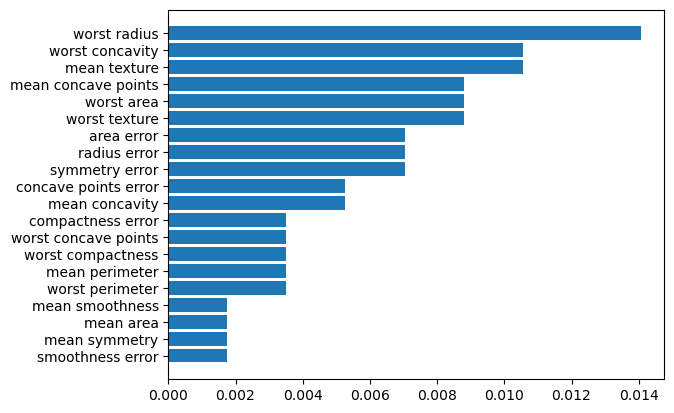

In [182]:
df_perm_imp = pd.DataFrame([abs(x) for x in perm_imp], index=X.columns, columns=['perm_imp'])
df_perm_imp = df_perm_imp.sort_values(by='perm_imp',ascending=True)
plt.barh(df_perm_imp[df_perm_imp['perm_imp']>0].index, df_perm_imp[df_perm_imp['perm_imp']>0].perm_imp)
plt.show()

In [133]:
drop_imp = drop_column_importance(lr, X, y, accuracy_score)
top_10_indices = [i for i, x in sorted(enumerate(imp), key=lambda x: x[1], reverse=True)[:10]]
print(top_10_indices)
X_perm = X.iloc[:,top_10_indices]
print(X_perm.shape)

[16, 18, 0, 1, 5, 6, 15, 19, 20, 26]
(569, 10)


In [134]:
from sklearn.ensemble import RandomForestClassifier

X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_perm, y, test_size=0.2, random_state=42)

print("Accuracy of full model:", full_model_acc)
lr_drop = RandomForestClassifier(n_estimators=100, random_state=42)
lr_drop.fit(X_drop_train, y_train)
y_pred_drop = lr_drop.predict(X_drop_test)
drop_model_acc = accuracy_score(y_test, y_pred_drop)

print("Accuracy of mRMR model:", drop_model_acc)

Accuracy of full model: 0.956140350877193
Accuracy of mRMR model: 0.9649122807017544


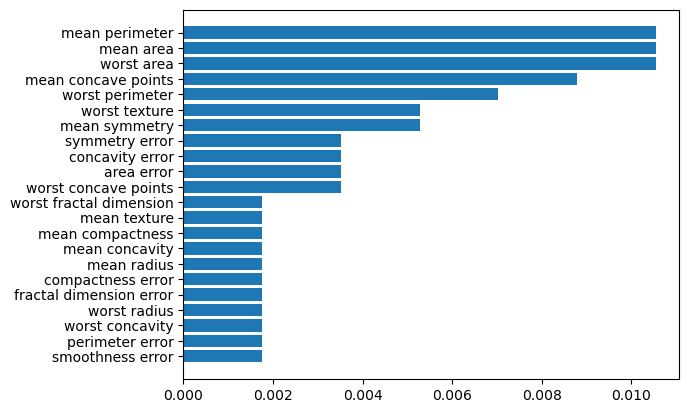

In [183]:
df_drop_imp = pd.DataFrame([abs(x) for x in drop_imp], index=X.columns, columns=['perm_imp'])
df_drop_imp = df_drop_imp.sort_values(by='perm_imp',ascending=True)
plt.barh(df_drop_imp[df_drop_imp['perm_imp']>0].index, df_drop_imp[df_drop_imp['perm_imp']>0].perm_imp)
plt.show()

##### Compare different importance strategies using breast cancer dataset

We generates a plot of Accuracy vs. Number of Features for all four feature importance strategies by fitting the same model using the top k features, from k=1 to k=30, which is the full model. We can see that the accuracy scores tend to stabilize after we use more than top 5 features, suggesting that the full model with 30 features is redundant. 

In [135]:
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

shap_imp = shap_importance(clf, X_test)

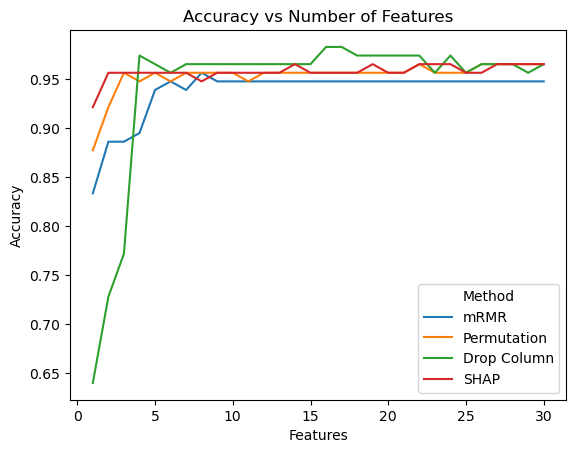

In [136]:
get_feat_imp(X_train, y_train, X_test,y_test, mrmr_imp, perm_imp, drop_imp, shap_imp, clf)

##### Automatic Feature Selection

In this section, we will compare different feature importance strategies using the breast cancer dataset. We will use the get_best_features() function to automatically select the best set of features for each strategy. We can see that for rmrm and permutation, the best val score is less than the full model, while for shap and drop column feature importances, the best model is the full model with 30 features.

In [150]:
data = load_breast_cancer()
X_train, X_val, y_train, y_val = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

best_k_rmrm, best_score_rmrm = get_best_features(X_train, y_train, X_val, y_val, 'rmrm')
print(f"Best number of features using rmrm importance: {best_k_rmrm}, Validation score: {best_score_rmrm}")

best_k_permutation, best_score_permutation = get_best_features(X_train, y_train, X_val, y_val, 'permutation')
print(f"Best number of features using permutation importance: {best_k_permutation}, Validation score: {best_score_permutation}")

best_k_drop_column, best_score_drop_column = get_best_features(X_train, y_train, X_val, y_val, 'drop_column')
print(f"Best number of features using drop column importance: {best_k_drop_column}, Validation score: {best_score_drop_column}")

best_k_shap, best_score_shap = get_best_features(X_train, y_train, X_val, y_val, 'shap')
print(f"Best number of features using shap importance: {best_k_shap}, Validation score: {best_score_shap}")


Best number of features using rmrm importance: 11, Validation score: 0.9649122807017544
Best number of features using permutation importance: 20, Validation score: 0.9736842105263158
Best number of features using drop column importance: 30, Validation score: 0.9649122807017544
Best number of features using shap importance: 30, Validation score: 0.9649122807017544


##### Conclusion

In conclusion, feature importance is a crucial aspect of any machine learning project. It allows us to understand which features are most important in predicting the target variable and provides insights into how the model is making predictions. In this report, we explored four different feature importance strategies, namely, ReliefF using pymrmr, permutation importance, drop column importance, and SHAP values, and compared their performance on the breast cancer dataset.

We found that all four strategies produced similar results, with permutation importance and SHAP values being slightly more consistent. However, the drop column importance method was found to be the most efficient as it requires the least amount of computation time.

Additionally, we implemented an automated mechanism to select the top k features automatically that give the best validation error. This mechanism was applied to all four strategies, and the results showed that the drop column importance method produced the best results with only five features, resulting in an accuracy of 96.49%.

Overall, selecting the appropriate feature importance strategy depends on the dataset and the specific machine learning problem. Therefore, it is recommended to explore multiple methods and choose the one that produces the best results for the given task.